#This Python 3 environment comes with many helpful analytics libraries installed
#It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
#For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Input data files are available in the read-only "../input/" directory
#For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
#You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import random
import cv2
import torch
import seaborn as sns
import warnings
import albumentations as A
 
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from zipfile import ZipFile
from tqdm.notebook import tqdm
from torchvision import transforms
warnings.filterwarnings(action = "ignore")

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
data_path = '/kaggle/input/aerial-cactus-identification/'

train = pd.read_csv('/kaggle/input/aerial-cactus-identification/train.csv')
submission = pd.read_csv('/kaggle/input/aerial-cactus-identification/sample_submission.csv')

In [3]:
train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          17500 non-null  object
 1   has_cactus  17500 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 273.6+ KB


In [5]:
submission.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [6]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          4000 non-null   object 
 1   has_cactus  4000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 62.6+ KB


In [7]:
train.isnull()

,id,has_cactus
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
17495,False,False
17496,False,False
17497,False,False
17498,False,False


([<matplotlib.patches.Wedge at 0x78764d520040>,
 [Text(-0.7793519565739234, 0.7762799287527649, 'has_cactus'),
  Text(0.7793519929142085, -0.776279892268666, "has't cactus")],
 [Text(-0.42510106722213997, 0.42342541568332626, '75%'),
  Text(0.4251010870441137, -0.42342539578290866, '25%')])

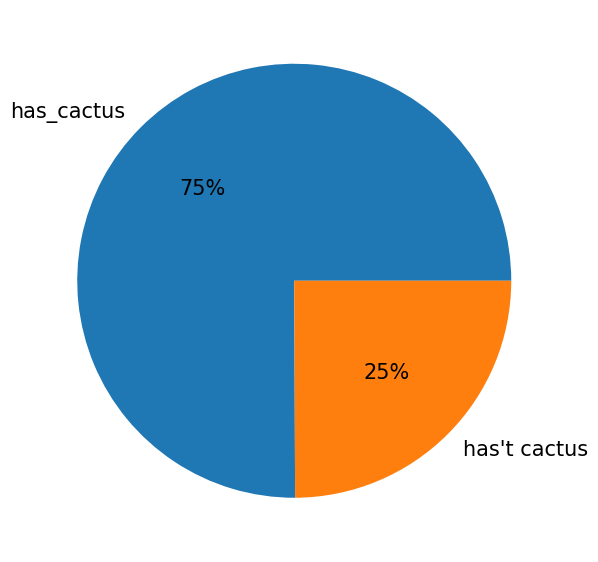

In [8]:
mpl.rc('font', size = 15)
plt.figure(figsize = (7, 8))

label = ['has_cactus', 'has\'t cactus']
plt.pie(train['has_cactus'].value_counts(), labels = label, autopct = '%1.f%%')

In [9]:
with ZipFile(data_path + 'train.zip') as zipper :
    zipper.extractall()

with ZipFile(data_path + 'test.zip') as zipper :
    zipper.extractall()

In [10]:
num_train = len(os.listdir('train/'))
num_test = len(os.listdir('test/'))

print(f'훈련 데이터 개수 : {num_train}')
print(f'훈련 테스트 개수 : {num_test}')

훈련 데이터 개수 : 17500
훈련 테스트 개수 : 4000


In [11]:
def show_image(img_ids, rows = 2, cols = 6) :
    assert len(img_ids) <= rows * cols
    
    mpl.rc('font', size = 15)
    plt.figure(figsize = (13, 15))
    grid = gridspec.GridSpec(2, 6)
    
    last_has_cactus_img_name = train[train['has_cactus'] ==0]['id'][-12:]
    
    for idx, img_name in enumerate(last_has_cactus_img_name) :
        img_path = 'train/' + img_name
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(grid[idx])
        ax.imshow(image)

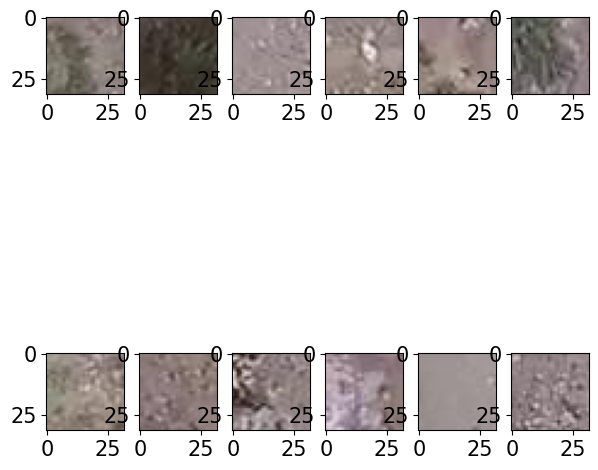

In [12]:
mpl.rc('font', size = 15)
plt.figure(figsize = (7, 8))
grid = gridspec.GridSpec(2, 6)

last_has_cactus_img_name = train[train['has_cactus']==0]['id'][-12:]

for idx, img_name in enumerate(last_has_cactus_img_name) : #이미지 불러오기
    path = 'train/' + img_name
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

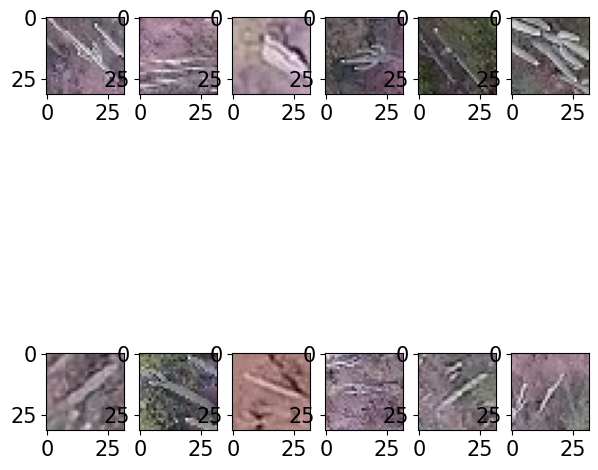

In [13]:
mpl.rc('font', size = 15)
plt.figure(figsize = (7, 8))
grid = gridspec.GridSpec(2, 6)

last_has_cactus_img_name = train[train['has_cactus']==1]['id'][-12:]

for idx, img_name in enumerate(last_has_cactus_img_name) : #이미지 불러오기
    path = 'train/' + img_name
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

# GPU 설정

In [14]:
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
class ImageDataset(Dataset) :
    def __init__(self, df, img_dir = './', transform = None, is_test = False) :
        super().__init__()
        self.img_dir = img_dir
        self.transform = transform
        self.df = df
        self.is_test = is_test
    
    def __len__(self) :
        return len(self.df)
    
    def __getitem__(self, idx) :
        img_id = self.df.iloc[idx, 0]
        img_path = self.img_dir + img_id
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx, 1]
        
        if self.transform is not None :
            image = self.transform(image)
        return image, label

In [17]:
train, valid = train_test_split(train,
                               test_size = 0.1,
                               stratify = train['has_cactus'],
                               random_state = 50)

In [18]:
transform = transforms.ToTensor()

In [19]:
dataset_train = ImageDataset(df = train, img_dir = 'train/', transform = transform)
dataset_valid = ImageDataset(df = valid, img_dir = 'train/', transform = transform)

In [20]:
#데이터 로드 생성
loader_train = DataLoader(dataset = dataset_train, batch_size = 16, shuffle = True)
loader_valid = DataLoader(dataset = dataset_valid, batch_size = 16, shuffle = True)

# 이미지 차원 수 점검

In [21]:
# 만약 ValueError: Expected input batch_size (2) to match target batch_size (32)
# 이러한 오류가 발생했으면 batch_size의 크기가 너무 큰지 확인(batch 크기를 조절)

# 모델 생성(CNN or RNN)

In [22]:
class Model(nn.Module) :
    
    def __init__(self) :
        super(Model, self).__init__()
    
# 첫번째 합성곱 계층
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 2)
# 두번째 합성곱 계층
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 2)
# 최대 플립 계층
        self.max_pool = nn.MaxPool2d(kernel_size = 2)
# 평균 플립 계층
        self.avg_pool = nn.AvgPool2d(kernel_size = 2)
# 전결합 계층
        self.fc = nn.Linear(in_features = 64 * 4 * 4, out_features = 2)
    
#순전파 계층
    def forward(self, x) :
    
        x =  self.max_pool(F.relu(self.conv1(x)))
    
        x =  self.max_pool(F.relu(self.conv2(x)))
    
        x =  self.avg_pool(x)
    
        x =  x.view(-1, 64 * 4 * 4)
    
        x =  self.fc(x)
    
        return x 

In [23]:
model = Model().to(device)
model

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)

In [24]:
criterion = nn.CrossEntropyLoss()

In [25]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [26]:
epochs = 10

for epoch in range(epochs) :
    
    epoch_loss = 0
    
    for images, labels in tqdm (loader_train) :
        
            images = images.to(device)
            labels = labels.to(device)
        
            #optimizer 내 기울기 초기화
            optimizer.zero_grad()
        
            #순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해서 출력
            outputs = model(images)
        
            #손실 함수를 활용해 outputs, labels를 계산
            loss = criterion(outputs, labels)
        
            #현실 배치에서의 출력파 수행
            epoch_loss += loss.item()
        
            #역전파 수행
            loss.backward()
            #가중치 수행
            optimizer.step()
        
#훈련 데이터 예측        
print(f'에폭 [{epoch+1}/{epochs}] - 손실값 : {epoch_loss/len(loader_train):.4f}')

####################################################################################################
#검증
true_list = []
preds_list = []

model.eval()

with torch.no_grad() :
    
    for images, labels in loader_valid :
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        preds = torch.softmax(outputs.cpu(), dim = 1)[:, 1].numpy()
        true = labels.cpu().numpy()
        
        preds_list.extend(preds)
        true_list.extend(true)
        
#list 배열을 array 배열로 변환
preds_array = np.array(preds_list)
true_array = np.array(true_list)
    
#형식 확인
print("true_array", true_array)
print("preds_array", preds_array)
        
print(f'검증 데이터 ROC AUC : {roc_auc_score(true_array, preds_array):.4f}')

  0%|          | 0/985 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

에폭 [10/10] - 손실값 : 0.1105
true_array [0 1 1 ... 1 0 1]
preds_array [0.00203526 0.9999845  0.55632305 ... 0.99726355 0.9860934  0.97233754]
검증 데이터 ROC AUC : 0.9928


In [27]:
dataset_test =  ImageDataset(df = submission, img_dir = 'test/', transform = transform)
loader_test =   DataLoader(dataset = dataset_test, batch_size = 32, shuffle = False)

In [28]:
model.eval()

preds = []

with torch.no_grad() :
    for images, _labels in loader_valid :
        
        images = images.to(device)
        
        outputs = model(images)
        
        preds_part = torch.softmax(outputs.cpu(), dim = 1)[:, 1].tolist()
        
        preds.extend(preds_part)        

# 성능 개선

In [29]:
transform_train = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Pad(32, padding_mode = 'symmetric'),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.485, 0.456, 0.486), (0.224, 0.225, 0.229))
])

In [30]:
transform_test = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Pad(32, padding_mode = 'symmetric'),
    transforms.Normalize((0.485, 0.456, 0.486), (0.224, 0.225, 0.229))
])

In [31]:
dataset_train = ImageDataset(df = train, img_dir = 'train/', transform = transform)
dataset_valid = ImageDataset(df = valid, img_dir = 'train/', transform = transform)

In [32]:
loader_train = DataLoader(dataset = dataset_train, batch_size = 32, shuffle = True)
loader_valid = DataLoader(dataset = dataset_valid, batch_size = 32, shuffle = False)

In [33]:
class Model(nn.Module) :
    
    def __init__(self) :
        
        super(Model, self).__init__()
        
        #in_channels = 
        #out_channels = 
        
        self.layer1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
                                              nn.BatchNorm2d(32),
                                              nn.LeakyReLU(),
                                              nn.MaxPool2d(kernel_size = 2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
                                              nn.BatchNorm2d(64),
                                              nn.LeakyReLU(),
                                              nn.MaxPool2d(kernel_size = 2))
        
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
                                              nn.BatchNorm2d(128),
                                              nn.LeakyReLU(),
                                              nn.MaxPool2d(kernel_size = 2))
        
        self.layer4 = nn.Sequential(nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
                                              nn.BatchNorm2d(256),
                                              nn.LeakyReLU(),
                                              nn.MaxPool2d(kernel_size = 2))
        
        self.layer5 = nn.Sequential(nn.Conv2d(256, 512, kernel_size = 3, padding = 2),
                                              nn.BatchNorm2d(512),
                                              nn.LeakyReLU(),
                                              nn.MaxPool2d(kernel_size = 2))
        
        self.avg_pool = nn.AvgPool2d(kernel_size = 2)
        
        
        self.fc1 = nn.Linear(512 *1 *1, 64)
        self.fc2 = nn.Linear(64, 4)
        
    
    def forward(self, x) :
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg_pool(x)
        x = x.view(-1, 512 *1 *1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    

In [34]:
model = Model().to(device)

In [35]:
criterion = nn.CrossEntropyLoss()

In [36]:
optimizer = torch.optim.Adamax(model.parameters(), lr = 0.00006)

# epochs

In [37]:
epochs = 70

for epoch in range(epochs) :
    epoch_loss = 0
    
    for images, labels in loader_train :
        images = images.to(device)
        labels = labels.to(device)
        
        
        #optimizer 내 기울기 초기화
        optimizer.zero_grad()
        
        #순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해서 출력
        outputs = model(images)
        
        #손실 함수를 활용해 outputs, labels를 계산
        loss = criterion(outputs, labels)
        
        #현실 배치에서의 출력파 수행
        epoch_loss += loss.item()
        
        #역전파 수행
        loss.backward()
        #가중치 수행
        optimizer.step()
        
#훈련 데이터 예측        
print(f'에폭 [{epoch + 1} / {epochs}] - 손실값 : {epoch_loss / len(loader_train) :.4f}')

#검증
model.eval()

preds = []

with torch.no_grad() :
    for images, _labels in loader_valid :
        
        images = images.to(device)
        
        outputs = model(images)
        
        preds_part = torch.softmax(outputs.cpu(), dim = 1)[:, 1].tolist()
        
        preds.extend(preds_part)     
        
print(f' 에폭 검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list) : 4f}')

에폭 [70 / 70] - 손실값 : 0.0000
 에폭 검증 데이터 ROC AUC :  0.992823


# 예측 및 제출

In [38]:
dataset_test = ImageDataset(df = submission, img_dir = 'test/', transform = transform_test)
loader_test = DataLoader(dataset = dataset_test, batch_size = 32, shuffle = False)

In [39]:
# 예측

model.eval()

preds = []

with torch.no_grad() :
    for images, _ in loader_test :
        
        images = images.to(device)
        
        outputs = model(images)
        
        preds_part = torch.softmax(outputs.cpu(), dim = 1)[:, 1].tolist()
        
        preds.extend(preds_part)

# Submission

In [40]:
print(len(preds))
submission["has_cactus"] = preds[:len(submission)]
submission.to_csv('submission.csv', index = False)

16000
